In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table, Column, ForeignKey, Integer, String, Float, DateTime, inspect, distinct, desc, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# save refernece to the table
Measurement = Base.classes.measurement
Station = Base.classes.station

session = Session(engine)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Hawaii Vacation for Jay!

In [14]:
vacay_start = str(date.today())
vacay_end = dt.datetime.strptime(vacay_start, '%Y-%m-%d')+ dt.timedelta(days=15)
vacay_start = dt.datetime.strptime(vacay_start, '%Y-%m-%d')
print(f"I will be on vacation in Hawaii from {vacay_start} to {vacay_end}. I could be there for my 43rd birthday on August, 26, 2020! ...but probably not ...Coronavirus and all.")

I will be on vacation in Hawaii from 2020-08-25 00:00:00 to 2020-09-09 00:00:00. I could be there for my 43rd birthday on August, 26, 2020! ...but probably not ...Coronavirus and all.


# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
end_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
begin_date=dt.datetime.strptime(end_date, '%Y-%m-%d')- relativedelta(years=1)
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
print(f'The data begins on {begin_date} and ends on {end_date}.')

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date>=begin_date).filter(Measurement.date<=end_date).all()

data_all_df = pd.DataFrame(session.query(Measurement.id,Measurement.station,Measurement.date, Measurement.prcp,\
                                         Measurement.tobs).all()).set_index('date')

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
last_year_data = pd.DataFrame(data).set_index('date').sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
last_year_data.head()

The data begins on 2016-08-23 00:00:00 and ends on 2017-08-23 00:00:00.


,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


C:\Users\jspea\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


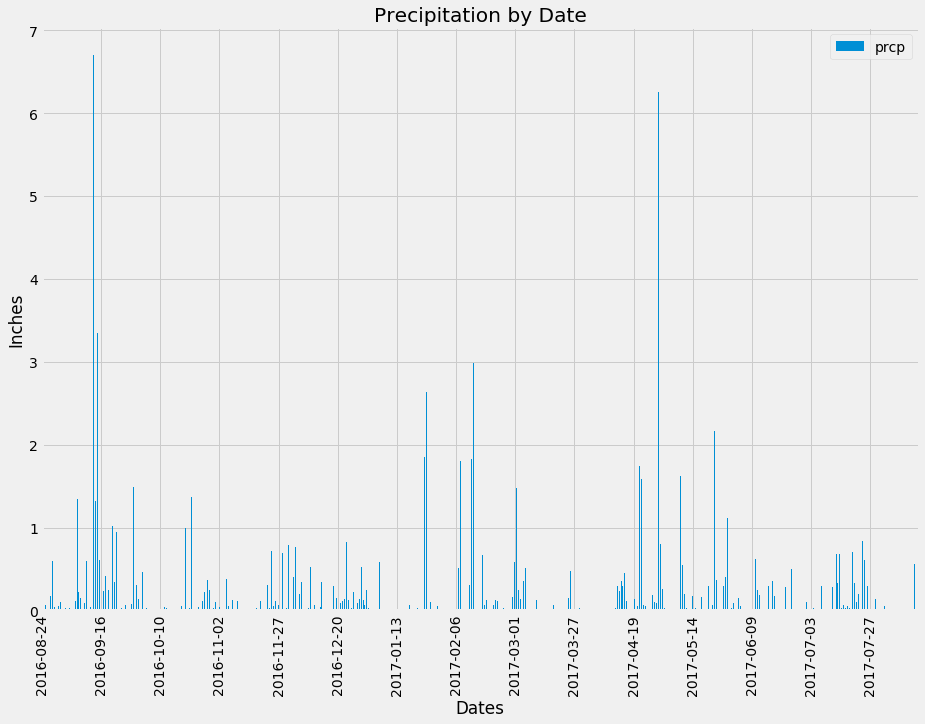

In [16]:
# set ticks and display bar graph from https://stackoverflow.com/questions/19143857/pandas-bar-plot-xtick-frequency
n = 150

ax = last_year_data.plot(kind='bar', y='prcp', figsize = [14,10])
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])
plt.xlabel('Dates')
plt.ylabel('Inches')
plt.title('Precipitation by Date')

ax.figure.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print('Precipitation Summary Data for Last Year of Available Data')
last_year_prcp = pd.DataFrame(last_year_data['prcp']).describe()
last_year_prcp

Precipitation Summary Data for Last Year of Available Data


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset.
stations, = session.query(func.count(distinct(Measurement.station))).order_by()
(f'There are {stations[0]} unique weather stations in the entire dataset.')

'There are 9 unique weather stations in the entire dataset.'

In [19]:
active_all = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(desc(func.count(Measurement.station))).all()
active_all_df=pd.DataFrame(active_all,columns = ["station","count"])
print('Observation counts returned for entire dataset.')
active_all_df = active_all_df.set_index('station')
active_all_df

Observation counts returned for entire dataset.


,count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_all = active_all_df.index[0]

print(f'The most active station in the entire dataset is: {most_active_all}.')

The most active station in the entire dataset is: USC00519281.


In [21]:
active_agg_all = data_all_df.loc[data_all_df["station"] == most_active_all]
print(f'Summary returned for {most_active_all}, the most active station')
active_agg_all = pd.DataFrame(active_agg_all["tobs"].agg(["mean", "max", "min"]))
active_agg_all

Summary returned for USC00519281, the most active station


,tobs
mean,71.663781
max,85.000000
min,54.000000


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = pd.DataFrame(session.query(Measurement.station,Measurement.tobs,Measurement.date).filter\
                         (Measurement.station == most_active_all).filter(Measurement.date>=begin_date).filter\
                         (Measurement.date<=end_date).all())
temp_data

,station,tobs,date
0,USC00519281,77.0,2016-08-24
1,USC00519281,80.0,2016-08-25
2,USC00519281,80.0,2016-08-26
3,USC00519281,75.0,2016-08-27
4,USC00519281,73.0,2016-08-28
...,...,...,...
346,USC00519281,77.0,2017-08-14
347,USC00519281,77.0,2017-08-15
348,USC00519281,76.0,2017-08-16
349,USC00519281,76.0,2017-08-17


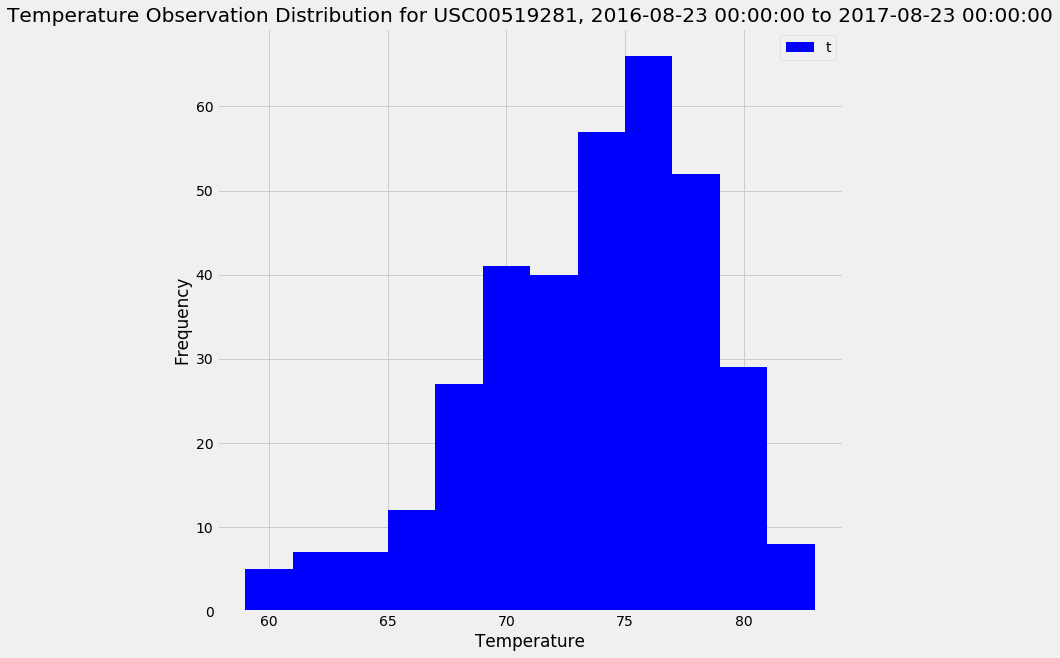

In [23]:
temp_data.hist(column='tobs', color = "blue", bins = 12, figsize = (10,10))
plt.title (f"Temperature Observation Distribution for {most_active_all}, {begin_date} to {end_date}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend("tobs")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
